In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("delivery_damage_data.csv")  # Update path if needed

# Preview the first few rows
print(df.head())

# Check data structure
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Basic statistics
print(df.describe())


  product_category vehicle_type weather  weight  fragility_score  distance  \
0             Food          Van   Rainy   12.67                7     82.16   
1         Clothing         Bike   Rainy    6.54               10     19.54   
2        Glassware          Van   Snowy    2.13                3     47.11   
3         Clothing          Van   Sunny    5.87                4     23.41   
4         Clothing          Van   Rainy    4.02                1     79.82   

  package_material  stacking_layer  damage_probability  
0          Plastic               2                0.68  
1      Bubble Wrap               3                0.49  
2             Foam               2                0.23  
3      Bubble Wrap               1                0.14  
4        Cardboard               5                0.33  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              ---------

In [2]:
# Create binary label: 1 = Damaged, 0 = Survived
df["label"] = df["damage_probability"].apply(lambda x: 1 if x > 0.5 else 0)

# Verify distribution of classes
print(df["label"].value_counts())


label
0    3703
1    1297
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# 1. Define features and target
X = df.drop(columns=["damage_probability", "label"])
y = df["label"]

# 2. Identify column types
categorical_cols = ["product_category", "vehicle_type", "weather", "package_material"]
numerical_cols = ["weight", "fragility_score", "distance", "stacking_layer"]

# 3. Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# 4. Full pipeline with a sample model (Random Forest Classifier)
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Fit the pipeline
model_pipeline.fit(X_train, y_train)

# 7. Evaluate basic accuracy
accuracy = model_pipeline.score(X_test, y_test)
print(f"Validation Accuracy: {accuracy:.2f}")


Validation Accuracy: 0.97


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       741
           1       0.96      0.93      0.95       259

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000



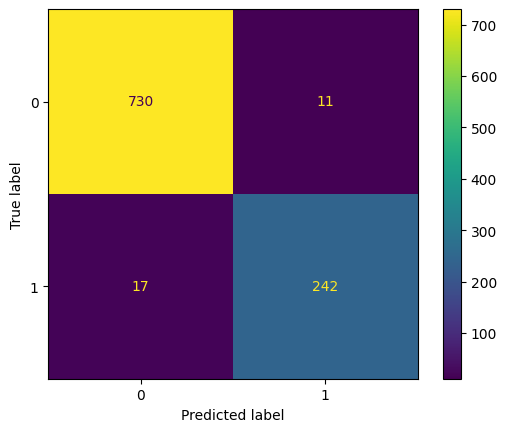

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Predict on test set
y_pred = model_pipeline.predict(X_test)

# 2. Classification report
print(classification_report(y_test, y_pred))

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [5]:
from sklearn.model_selection import GridSearchCV

# Define parameters to search
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10]
}

# Create GridSearchCV with pipeline
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5,
    scoring="f1",  # Optimizing for F1-score
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best params
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Re-evaluate
from sklearn.metrics import classification_report
y_pred_tuned = best_model.predict(X_test)
print(classification_report(y_test, y_pred_tuned))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       741
           1       0.96      0.93      0.94       259

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000



In [6]:
import joblib

# Save your trained or best model
joblib.dump(best_model, "delivery_damage_model.pkl")  # Make sure best_model is defined


['delivery_damage_model.pkl']

In [7]:
import joblib
import pandas as pd

# Load model from disk (ensure file exists)
model = joblib.load("delivery_damage_model.pkl")

# Test with an example input
input_data = pd.DataFrame([{
    "product_category": "Glassware",
    "vehicle_type": "Van",
    "weather": "Rainy",
    "weight": 4.5,
    "fragility_score": 8,
    "distance": 50,
    "package_material": "Foam",
    "stacking_layer": 2
}])

prediction = model.predict(input_data)
probability = model.predict_proba(input_data)

print("Predicted Label:", prediction[0])
print("Probability (Damaged):", probability[0][1])


Predicted Label: 0
Probability (Damaged): 0.015


In [8]:
!pip install fastapi uvicorn nest-asyncio pyngrok joblib pandas


In [ ]:
import nest_asyncio
import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd
from pyngrok import ngrok

# Allow nested event loops (needed in environments like Google Colab)
nest_asyncio.apply()

# ✅ Set your ngrok auth token (REQUIRED to avoid ERR_NGROK_4018)
ngrok.set_auth_token("2yK7X4EcHS8TzDr5uEbP36Cy57k_7AcEncUXZe745yEb69dwc")  # <- Replace with your token

# Load your trained model
model = joblib.load("delivery_damage_model.pkl")

# Create FastAPI app
app = FastAPI(title="Delivery Damage Predictor")

from fastapi.middleware.cors import CORSMiddleware

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Change this in production!
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Define input schema
class DeliveryItem(BaseModel):
    product_category: str
    vehicle_type: str
    weather: str
    weight: float
    fragility_score: int
    distance: float
    package_material: str
    stacking_layer: int

# Prediction route
@app.post("/predict")
def predict(data: DeliveryItem):
    input_df = pd.DataFrame([data.dict()])
    prediction = model.predict(input_df)[0]
    probability = model.predict_proba(input_df)[0][1]

    advice = (
        "High damage risk — improve packaging or choose safer transport"
        if probability > 0.5 else "Safe to ship"
    )

    return {
        "predicted_label": int(prediction),
        "damage_probability": round(probability, 3),
        "advice": advice
    }

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print("🔗 Public URL:", public_url)

# Run FastAPI app
uvicorn.run(app, host="0.0.0.0", port=8000)


INFO:     Started server process [320]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


🔗 Public URL: NgrokTunnel: "https://3bc5-35-243-248-151.ngrok-free.app" -> "http://localhost:8000"
INFO:     2401:4900:88eb:69ac:61a2:9683:9250:27b6:0 - "GET / HTTP/1.1" 404 Not Found
INFO:     2401:4900:88eb:69ac:61a2:9683:9250:27b6:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     2401:4900:88eb:69ac:61a2:9683:9250:27b6:0 - "GET / HTTP/1.1" 404 Not Found
INFO:     106.219.122.165:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-10-38762499>:45: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  input_df = pd.DataFrame([data.dict()])


INFO:     106.219.122.165:0 - "POST /predict HTTP/1.1" 200 OK


<ipython-input-10-38762499>:45: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  input_df = pd.DataFrame([data.dict()])
